### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import balanced_accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset

In [29]:
color_train_root = '/content/drive/MyDrive/liders_hack/datasets/super_res/colors'
color_test_root = '/content/drive/MyDrive/liders_hack/datasets/super_res/test/colors'
transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.4, hue=0.)
])
colors_train = ImageFolder(color_train_root, transform=transform)
colors_test = ImageFolder(color_test_root, transform=transform)

In [20]:
len(colors_train), len(colors_test)

(954, 185)

### Dataloader

In [30]:
BATCH_SIZE = 16
train_dataloader = DataLoader(colors_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(colors_test, batch_size=BATCH_SIZE, shuffle=True)

### Model

In [43]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [44]:
model.fc.in_features

2048

In [45]:
model.eval()
for param in model.parameters():
    param.requires_grad_(False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=3)
model.fc.requires_grad_(True)

Linear(in_features=2048, out_features=3, bias=True)

### Now let's train the model

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [47]:
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([1., 1., 1.])).to(device)
optimizer = torch.optim.Adam(params=model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [48]:
_ = model.to(device)

In [49]:
n_epochs = 100
epoch_train_loss = []
epoch_test_loss = []
best_test_acc = 0
best_test_epoch = 0

for epoch in range(n_epochs):
    running_loss = []
    true_target = []
    pred_target = []
    
    running_test_loss = []
    true_test_target = []
    pred_test_target = []
    
    # model.train()
    for img, target in tqdm(train_dataloader):
        img, target = img.to(device).float(), target.to(device)
        optimizer.zero_grad()
        preds = model(img)
        loss = loss_func(preds, target)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        preds = preds.argmax(dim=1)
        pred_target.extend(list(preds.detach().cpu().numpy()))
        true_target.extend(list(target.detach().cpu().numpy()))
    scheduler.step()
    # model.eval()
    for img, target in tqdm(test_dataloader):
        img, target = img.to(device).float(), target.to(device)
        preds = model(img)
        loss = loss_func(preds, target)
        
        running_test_loss.append(loss.item())
        preds = preds.argmax(dim=1)
        pred_test_target.extend(list(preds.detach().cpu().numpy()))
        true_test_target.extend(list(target.detach().cpu().numpy()))

    print(f'Epoch {epoch} mean train loss {np.mean(running_loss)}')
    print(f'Epoch {epoch} mean test loss {np.mean(running_test_loss)}')
    print(f'Epoch {epoch} train balanced accuracy {balanced_accuracy_score(true_target, pred_target)}')
    print(f'Epoch {epoch} test balanced accuracy {balanced_accuracy_score(true_test_target, pred_test_target)}')
    epoch_train_loss.append(np.mean(running_loss))
    epoch_test_loss.append(np.mean(running_test_loss))

    if balanced_accuracy_score(true_test_target, pred_test_target) > best_test_acc:
        best_test_acc = balanced_accuracy_score(true_test_target, pred_test_target)
        best_test_epoch = epoch
        torch.save(model.state_dict(), '/content/drive/MyDrive/liders_hack/models/color_resnet50.pth')

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0 mean train loss 1.005879525343577
Epoch 0 mean test loss 1.0425993998845418
Epoch 0 train balanced accuracy 0.4876981468182248
Epoch 0 test balanced accuracy 0.5976190476190476


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 mean train loss 0.7856459538141887
Epoch 1 mean test loss 0.9330000579357147
Epoch 1 train balanced accuracy 0.6499895643332164
Epoch 1 test balanced accuracy 0.625014985014985


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 mean train loss 0.7492242286602656
Epoch 2 mean test loss 0.8118391384681066
Epoch 2 train balanced accuracy 0.6705740816064756
Epoch 2 test balanced accuracy 0.6174825174825175


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 mean train loss 0.7016744494438172
Epoch 3 mean test loss 0.9439746836821238
Epoch 3 train balanced accuracy 0.6968041598412767
Epoch 3 test balanced accuracy 0.6622077922077922


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 mean train loss 0.7111632093787194
Epoch 4 mean test loss 0.7924837370713552
Epoch 4 train balanced accuracy 0.6808317183593123
Epoch 4 test balanced accuracy 0.648051948051948


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 mean train loss 0.6657934799790383
Epoch 5 mean test loss 0.9583917409181595
Epoch 5 train balanced accuracy 0.7132393686631584
Epoch 5 test balanced accuracy 0.6330902430902431


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6 mean train loss 0.640978009502093
Epoch 6 mean test loss 0.8088963578144709
Epoch 6 train balanced accuracy 0.7189263735030972
Epoch 6 test balanced accuracy 0.6950216450216451


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7 mean train loss 0.6416697959105174
Epoch 7 mean test loss 0.8605465243260065
Epoch 7 train balanced accuracy 0.7271657236747847
Epoch 7 test balanced accuracy 0.6616183816183816


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8 mean train loss 0.6644213815530141
Epoch 8 mean test loss 0.9131899376710256
Epoch 8 train balanced accuracy 0.7020367550682248
Epoch 8 test balanced accuracy 0.6384815184815184


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9 mean train loss 0.6249660352865855
Epoch 9 mean test loss 0.8787660797437032
Epoch 9 train balanced accuracy 0.727477560913569
Epoch 9 test balanced accuracy 0.6092474192474193


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10 mean train loss 0.5825212230285008
Epoch 10 mean test loss 0.8895829046765963
Epoch 10 train balanced accuracy 0.757824456936321
Epoch 10 test balanced accuracy 0.6139094239094239


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11 mean train loss 0.5781907898684343
Epoch 11 mean test loss 0.7980647285779318
Epoch 11 train balanced accuracy 0.7543302898043901
Epoch 11 test balanced accuracy 0.6973393273393272


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12 mean train loss 0.5673051436742147
Epoch 12 mean test loss 0.8978254149357477
Epoch 12 train balanced accuracy 0.7573338897072149
Epoch 12 test balanced accuracy 0.6558874458874459


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13 mean train loss 0.5692698587973912
Epoch 13 mean test loss 0.9101993863781294
Epoch 13 train balanced accuracy 0.7601708678766023
Epoch 13 test balanced accuracy 0.6313153513153513


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14 mean train loss 0.5743730127811432
Epoch 14 mean test loss 0.8975372066100439
Epoch 14 train balanced accuracy 0.7462848493445547
Epoch 14 test balanced accuracy 0.6501298701298701


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15 mean train loss 0.5704447865486145
Epoch 15 mean test loss 0.8863435884316763
Epoch 15 train balanced accuracy 0.7798035863131608
Epoch 15 test balanced accuracy 0.6667166167166169


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16 mean train loss 0.5839405223727226
Epoch 16 mean test loss 0.8137434422969818
Epoch 16 train balanced accuracy 0.744693172487207
Epoch 16 test balanced accuracy 0.6493806193806194


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17 mean train loss 0.5735820524394513
Epoch 17 mean test loss 0.8400540053844452
Epoch 17 train balanced accuracy 0.7707901434735461
Epoch 17 test balanced accuracy 0.6666000666000665


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18 mean train loss 0.5589392962555091
Epoch 18 mean test loss 0.853208045164744
Epoch 18 train balanced accuracy 0.7695291505292019
Epoch 18 test balanced accuracy 0.6094971694971695


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19 mean train loss 0.5562262937426568
Epoch 19 mean test loss 0.7898322666684786
Epoch 19 train balanced accuracy 0.76128928844674
Epoch 19 test balanced accuracy 0.656020646020646


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20 mean train loss 0.5583588421344757
Epoch 20 mean test loss 0.8651297191778818
Epoch 20 train balanced accuracy 0.764877250169103
Epoch 20 test balanced accuracy 0.6398001998001998


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21 mean train loss 0.5635632241765658
Epoch 21 mean test loss 0.8529064754645029
Epoch 21 train balanced accuracy 0.7745353453808713
Epoch 21 test balanced accuracy 0.6650316350316351


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 22 mean train loss 0.5594554757078488
Epoch 22 mean test loss 0.8272745261589686
Epoch 22 train balanced accuracy 0.7605120407368983
Epoch 22 test balanced accuracy 0.6801831501831502


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 23 mean train loss 0.5717311874032021
Epoch 23 mean test loss 0.8903659532467524
Epoch 23 train balanced accuracy 0.7530436281912231
Epoch 23 test balanced accuracy 0.6322244422244422


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 24 mean train loss 0.5559013607601325
Epoch 24 mean test loss 0.8397472649812698
Epoch 24 train balanced accuracy 0.782194512596484
Epoch 24 test balanced accuracy 0.6544522144522144


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 25 mean train loss 0.561193186789751
Epoch 25 mean test loss 0.8825982759396235
Epoch 25 train balanced accuracy 0.7672891543470115
Epoch 25 test balanced accuracy 0.657955377955378


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 26 mean train loss 0.5552922666072846
Epoch 26 mean test loss 0.9307271291812261
Epoch 26 train balanced accuracy 0.7742633327108916
Epoch 26 test balanced accuracy 0.6060839160839161


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 27 mean train loss 0.5521972643832366
Epoch 27 mean test loss 0.8327745248874029
Epoch 27 train balanced accuracy 0.7766212564200141
Epoch 27 test balanced accuracy 0.6464668664668665


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 28 mean train loss 0.5604204793771108
Epoch 28 mean test loss 0.8329505970080694
Epoch 28 train balanced accuracy 0.777574079078263
Epoch 28 test balanced accuracy 0.6462171162171163


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 29 mean train loss 0.550916501134634
Epoch 29 mean test loss 0.8513728777567545
Epoch 29 train balanced accuracy 0.7714069959565109
Epoch 29 test balanced accuracy 0.6331335331335332


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 30 mean train loss 0.5690425897638003
Epoch 30 mean test loss 0.8716325263182322
Epoch 30 train balanced accuracy 0.7582972013127565
Epoch 30 test balanced accuracy 0.6264668664668664


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 31 mean train loss 0.5504555774231752
Epoch 31 mean test loss 0.8831567019224167
Epoch 31 train balanced accuracy 0.7703247330024885
Epoch 31 test balanced accuracy 0.6703796203796205


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 32 mean train loss 0.572005708515644
Epoch 32 mean test loss 0.8455912868181864
Epoch 32 train balanced accuracy 0.7616121265435912
Epoch 32 test balanced accuracy 0.6535431235431236


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 33 mean train loss 0.567833814273278
Epoch 33 mean test loss 0.8990251819292704
Epoch 33 train balanced accuracy 0.7527789494266214
Epoch 33 test balanced accuracy 0.6522244422244422


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 34 mean train loss 0.5458553291857242
Epoch 34 mean test loss 0.8622640122969946
Epoch 34 train balanced accuracy 0.7733021523257162
Epoch 34 test balanced accuracy 0.648035298035298


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 35 mean train loss 0.5460590188701947
Epoch 35 mean test loss 0.8871750434239706
Epoch 35 train balanced accuracy 0.7745819919442796
Epoch 35 test balanced accuracy 0.6655311355311355


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 36 mean train loss 0.541957750916481
Epoch 36 mean test loss 0.8772620062033335
Epoch 36 train balanced accuracy 0.7865948558232557
Epoch 36 test balanced accuracy 0.6292207792207792


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 37 mean train loss 0.552138697852691
Epoch 37 mean test loss 0.8305296450853348
Epoch 37 train balanced accuracy 0.7691989785269727
Epoch 37 test balanced accuracy 0.6496303696303696


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 38 mean train loss 0.5589139262835184
Epoch 38 mean test loss 0.9038913498322169
Epoch 38 train balanced accuracy 0.7657446359638463
Epoch 38 test balanced accuracy 0.6455577755577755


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 39 mean train loss 0.5436851729949316
Epoch 39 mean test loss 0.8777907689412435
Epoch 39 train balanced accuracy 0.7900491983863819
Epoch 39 test balanced accuracy 0.6602097902097902


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 40 mean train loss 0.562259604036808
Epoch 40 mean test loss 0.8471186111370722
Epoch 40 train balanced accuracy 0.7529220337116019
Epoch 40 test balanced accuracy 0.640959040959041


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 41 mean train loss 0.5652914101878802
Epoch 41 mean test loss 0.9263165841499964
Epoch 41 train balanced accuracy 0.7593826193086936
Epoch 41 test balanced accuracy 0.6322244422244422


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 42 mean train loss 0.5519651859998703
Epoch 42 mean test loss 0.8574698120355606
Epoch 42 train balanced accuracy 0.7655580601573723
Epoch 42 test balanced accuracy 0.6604595404595405


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 43 mean train loss 0.551383929948012
Epoch 43 mean test loss 0.8708015183607737
Epoch 43 train balanced accuracy 0.7775855918471043
Epoch 43 test balanced accuracy 0.6473759573759573


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 44 mean train loss 0.5512877315282821
Epoch 44 mean test loss 0.858446404337883
Epoch 44 train balanced accuracy 0.778685677653797
Epoch 44 test balanced accuracy 0.6428038628038628


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 45 mean train loss 0.5585736237466336
Epoch 45 mean test loss 0.8599891240398089
Epoch 45 train balanced accuracy 0.7682273091945045
Epoch 45 test balanced accuracy 0.6726073926073927


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 46 mean train loss 0.5593449945251147
Epoch 46 mean test loss 0.900671069820722
Epoch 46 train balanced accuracy 0.7856195195380985
Epoch 46 test balanced accuracy 0.647126207126207


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 47 mean train loss 0.5599010681112607
Epoch 47 mean test loss 0.8624036659797033
Epoch 47 train balanced accuracy 0.7723781533782047
Epoch 47 test balanced accuracy 0.6319746919746919


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 48 mean train loss 0.5503356213370959
Epoch 48 mean test loss 0.8591749221086502
Epoch 48 train balanced accuracy 0.7603322869250279
Epoch 48 test balanced accuracy 0.6343190143190144


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 49 mean train loss 0.5570952629049619
Epoch 49 mean test loss 0.8521530677874883
Epoch 49 train balanced accuracy 0.7615901248274574
Epoch 49 test balanced accuracy 0.6531335331335332


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 50 mean train loss 0.5554627830783526
Epoch 50 mean test loss 0.85666473954916
Epoch 50 train balanced accuracy 0.7612934673102032
Epoch 50 test balanced accuracy 0.6512887112887112


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 51 mean train loss 0.5511349072058995
Epoch 51 mean test loss 0.8403430307904879
Epoch 51 train balanced accuracy 0.7842149303979994
Epoch 51 test balanced accuracy 0.6455311355311356


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 52 mean train loss 0.5540320421258609
Epoch 52 mean test loss 0.8034287989139557
Epoch 52 train balanced accuracy 0.7530646060858084
Epoch 52 test balanced accuracy 0.6866000666000666


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 53 mean train loss 0.5613324247300625
Epoch 53 mean test loss 0.8340778599182764
Epoch 53 train balanced accuracy 0.7677723876707399
Epoch 53 test balanced accuracy 0.631155511155511


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 54 mean train loss 0.5618050654729208
Epoch 54 mean test loss 0.8940253257751465
Epoch 54 train balanced accuracy 0.7673033102469932
Epoch 54 test balanced accuracy 0.6482850482850483


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 55 mean train loss 0.5618798260887464
Epoch 55 mean test loss 0.89182381828626
Epoch 55 train balanced accuracy 0.7592363799817982
Epoch 55 test balanced accuracy 0.6143190143190144


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 56 mean train loss 0.5558456932504972
Epoch 56 mean test loss 0.8554424444834391
Epoch 56 train balanced accuracy 0.7636618799666183
Epoch 56 test balanced accuracy 0.6469663669663669


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 57 mean train loss 0.5618274196982384
Epoch 57 mean test loss 0.8568266580502192
Epoch 57 train balanced accuracy 0.7668373878651614
Epoch 57 test balanced accuracy 0.6570462870462871


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 58 mean train loss 0.5523480052749316
Epoch 58 mean test loss 0.8768579910198847
Epoch 58 train balanced accuracy 0.7628736313987097
Epoch 58 test balanced accuracy 0.6535431235431236


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 59 mean train loss 0.5595578809579214
Epoch 59 mean test loss 0.8983460466066996
Epoch 59 train balanced accuracy 0.7690307374839436
Epoch 59 test balanced accuracy 0.6473759573759573


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 60 mean train loss 0.5576661124825477
Epoch 60 mean test loss 0.864531010389328
Epoch 60 train balanced accuracy 0.7704714842401582
Epoch 60 test balanced accuracy 0.6033300033300034


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 61 mean train loss 0.5625647942225138
Epoch 61 mean test loss 0.863885353008906
Epoch 61 train balanced accuracy 0.7690417383420104
Epoch 61 test balanced accuracy 0.6859407259407261


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 62 mean train loss 0.5767538219690322
Epoch 62 mean test loss 0.9103908513983091
Epoch 62 train balanced accuracy 0.7624187098749448
Epoch 62 test balanced accuracy 0.6358874458874458


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 63 mean train loss 0.5620596533020338
Epoch 63 mean test loss 0.8880825986464819
Epoch 63 train balanced accuracy 0.7815378355447148
Epoch 63 test balanced accuracy 0.6233300033300032


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 64 mean train loss 0.5622741649548213
Epoch 64 mean test loss 0.8453729748725891
Epoch 64 train balanced accuracy 0.7766354123199957
Epoch 64 test balanced accuracy 0.6402997002997003


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 65 mean train loss 0.5547178998589516
Epoch 65 mean test loss 0.8897692312796911
Epoch 65 train balanced accuracy 0.7821615100222831
Epoch 65 test balanced accuracy 0.6591142191142191


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 66 mean train loss 0.5565026943882306
Epoch 66 mean test loss 0.9115047951539358
Epoch 66 train balanced accuracy 0.7772480859394971
Epoch 66 test balanced accuracy 0.618891108891109


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 67 mean train loss 0.552079272766908
Epoch 67 mean test loss 0.8577021360397339
Epoch 67 train balanced accuracy 0.770618747388602
Epoch 67 test balanced accuracy 0.6285614385614385


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 68 mean train loss 0.5537564903497696
Epoch 68 mean test loss 0.8288039515415827
Epoch 68 train balanced accuracy 0.7720411593813719
Epoch 68 test balanced accuracy 0.6565467865467866


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 69 mean train loss 0.5587530458966891
Epoch 69 mean test loss 0.8738753696282705
Epoch 69 train balanced accuracy 0.7622431349265376
Epoch 69 test balanced accuracy 0.6387312687312687


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 70 mean train loss 0.5616988802949587
Epoch 70 mean test loss 0.8467993338902792
Epoch 70 train balanced accuracy 0.7734997289902572
Epoch 70 test balanced accuracy 0.6531335331335332


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 71 mean train loss 0.5601354464888573
Epoch 71 mean test loss 0.804410383105278
Epoch 71 train balanced accuracy 0.7726606549954772
Epoch 71 test balanced accuracy 0.6416183816183817


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 72 mean train loss 0.5570932308832804
Epoch 72 mean test loss 0.8960619072119395
Epoch 72 train balanced accuracy 0.7666361442479314
Epoch 72 test balanced accuracy 0.6468764568764569


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 73 mean train loss 0.5639157781998316
Epoch 73 mean test loss 0.8778435364365578
Epoch 73 train balanced accuracy 0.758135782264331
Epoch 73 test balanced accuracy 0.6212354312354312


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 74 mean train loss 0.5509669293959936
Epoch 74 mean test loss 0.8531593432029089
Epoch 74 train balanced accuracy 0.774241842905532
Epoch 74 test balanced accuracy 0.660959040959041


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 75 mean train loss 0.5678488289316496
Epoch 75 mean test loss 0.8735069756706556
Epoch 75 train balanced accuracy 0.7704641503347802
Epoch 75 test balanced accuracy 0.6361371961371961


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 76 mean train loss 0.552010943988959
Epoch 76 mean test loss 0.8332405587037405
Epoch 76 train balanced accuracy 0.7693315738646609
Epoch 76 test balanced accuracy 0.6676257076257076


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 77 mean train loss 0.5489356915156046
Epoch 77 mean test loss 0.8453243722518285
Epoch 77 train balanced accuracy 0.7774168388933007
Epoch 77 test balanced accuracy 0.6506293706293707


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 78 mean train loss 0.5637654249866804
Epoch 78 mean test loss 0.8917778531710306
Epoch 78 train balanced accuracy 0.7649202297798222
Epoch 78 test balanced accuracy 0.6466000666000665


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 79 mean train loss 0.5651653662323952
Epoch 79 mean test loss 0.8614107022682825
Epoch 79 train balanced accuracy 0.7578024552201871
Epoch 79 test balanced accuracy 0.6425541125541124


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 80 mean train loss 0.5544240643580755
Epoch 80 mean test loss 0.8535665273666382
Epoch 80 train balanced accuracy 0.7717219882372097
Epoch 80 test balanced accuracy 0.6438727938727938


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 81 mean train loss 0.5540800780057907
Epoch 81 mean test loss 0.8394099920988083
Epoch 81 train balanced accuracy 0.7826525891621636
Epoch 81 test balanced accuracy 0.6664668664668665


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 82 mean train loss 0.57482458204031
Epoch 82 mean test loss 0.8894213785727819
Epoch 82 train balanced accuracy 0.7514839300865277
Epoch 82 test balanced accuracy 0.6299966699966699


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 83 mean train loss 0.5549540027976037
Epoch 83 mean test loss 0.8509032626946768
Epoch 83 train balanced accuracy 0.7791689109775254
Epoch 83 test balanced accuracy 0.7001831501831502


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 84 mean train loss 0.544972388446331
Epoch 84 mean test loss 0.8541103303432465
Epoch 84 train balanced accuracy 0.7663457968145068
Epoch 84 test balanced accuracy 0.6756110556110556


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 85 mean train loss 0.5466420223315557
Epoch 85 mean test loss 0.8831803997357687
Epoch 85 train balanced accuracy 0.7848747624916833
Epoch 85 test balanced accuracy 0.6322244422244422


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 86 mean train loss 0.5606615652640661
Epoch 86 mean test loss 0.8370978285868963
Epoch 86 train balanced accuracy 0.7524739341824408
Epoch 86 test balanced accuracy 0.671948051948052


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 87 mean train loss 0.5502482761939367
Epoch 87 mean test loss 0.8654223730166754
Epoch 87 train balanced accuracy 0.7680952257675909
Epoch 87 test balanced accuracy 0.6613686313686314


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 88 mean train loss 0.5645432313283284
Epoch 88 mean test loss 0.8656377494335175
Epoch 88 train balanced accuracy 0.7623898861642072
Epoch 88 test balanced accuracy 0.6139094239094239


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 89 mean train loss 0.5596468150615692
Epoch 89 mean test loss 0.867570161819458
Epoch 89 train balanced accuracy 0.7713959950984438
Epoch 89 test balanced accuracy 0.6382317682317682


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 90 mean train loss 0.545361173649629
Epoch 90 mean test loss 0.8436985686421394
Epoch 90 train balanced accuracy 0.7709264057639231
Epoch 90 test balanced accuracy 0.625148185148185


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 91 mean train loss 0.5440098891655604
Epoch 91 mean test loss 0.878608708580335
Epoch 91 train balanced accuracy 0.7772517528921862
Epoch 91 test balanced accuracy 0.6462171162171163


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 92 mean train loss 0.5641222521662712
Epoch 92 mean test loss 0.8887094457944235
Epoch 92 train balanced accuracy 0.7723634855674488
Epoch 92 test balanced accuracy 0.646057276057276


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 93 mean train loss 0.5585798467199008
Epoch 93 mean test loss 0.8573505779107412
Epoch 93 train balanced accuracy 0.7679191389084093
Epoch 93 test balanced accuracy 0.6230536130536131


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 94 mean train loss 0.5605305189887683
Epoch 94 mean test loss 0.8821188062429428
Epoch 94 train balanced accuracy 0.7627132361718326
Epoch 94 test balanced accuracy 0.617982017982018


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 95 mean train loss 0.5332815100749334
Epoch 95 mean test loss 0.848413680990537
Epoch 95 train balanced accuracy 0.7788575856495155
Epoch 95 test balanced accuracy 0.6175724275724276


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 96 mean train loss 0.537016574293375
Epoch 96 mean test loss 0.8714452584584554
Epoch 96 train balanced accuracy 0.7821578430695942
Epoch 96 test balanced accuracy 0.6333832833832834


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 97 mean train loss 0.5563461569448312
Epoch 97 mean test loss 0.9087101568778356
Epoch 97 train balanced accuracy 0.7676261483438444
Epoch 97 test balanced accuracy 0.589087579087579


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 98 mean train loss 0.5558078303933144
Epoch 98 mean test loss 0.8987552920977274
Epoch 98 train balanced accuracy 0.759558706167875
Epoch 98 test balanced accuracy 0.62004995004995


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 99 mean train loss 0.5373910198609034
Epoch 99 mean test loss 0.8171765531102816
Epoch 99 train balanced accuracy 0.7695249716657386
Epoch 99 test balanced accuracy 0.6602997002997003


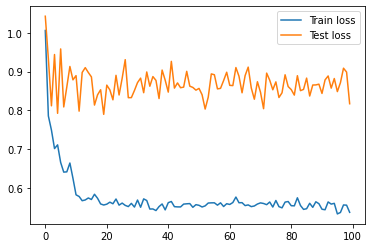

In [50]:
plt.plot(epoch_train_loss, label='Train loss')
plt.plot(epoch_test_loss, label='Test loss')
plt.legend()
plt.show()

In [51]:
best_test_acc, best_test_epoch

(0.7001831501831502, 83)